<a href="https://colab.research.google.com/github/ankit-rathi/AR-Talks/blob/master/Rough_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from datetime import datetime
from scipy.optimize import newton

def calculate_xirr(dates, cash_flows):
    def xnpv(rate):
        return sum(cf / ((1 + rate) ** ((date - dates[0]).days / 365)) for date, cf in zip(dates, cash_flows))
    return newton(xnpv, 0.1)

# Load data
df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myInvestments.csv')
df['Date'] = pd.to_datetime(df['Date'], format="%d-%b-%y")

# Extract inputs
dates = list(df['Date'])
cash_flows = list(df['Investment'])

# Define corpus
today = pd.to_datetime('30-Aug-2026', format="%d-%b-%Y") #pd.to_datetime(datetime.today().date())
corpus_value = 17250000  # Replace with actual

# Append current corpus
dates_with_corpus = dates + [today]
cash_flows_with_corpus = cash_flows + [corpus_value]

# XIRR calculation
xirr_with_corpus = calculate_xirr(dates_with_corpus, cash_flows_with_corpus)

# Absolute return
total_investment = -sum([cf for cf in cash_flows])
absolute_return = corpus_value - total_investment
absolute_return_pct = (absolute_return / total_investment) * 100

# Results
print(f"📊 Total Investment ₹{total_investment}")
print(f"📊 XIRR with current corpus ₹{corpus_value} ({xirr_with_corpus * 100:.2f}%)")
print(f"📈 Absolute Return: ₹{absolute_return} ({absolute_return_pct:.2f}%)")

📊 Total Investment ₹12982407
📊 XIRR with current corpus ₹17250000 (11.84%)
📈 Absolute Return: ₹4267593 (32.87%)


In [2]:
import yfinance as yf
import pandas as pd

def backtest_52w_low_to_ath(ticker: str, start='2010-01-01') -> pd.DataFrame:
    data = yf.download(ticker + '.NS', start=start)
    data = data[['Close']].dropna()
    data['52w_low'] = data['Close'].rolling(window=252).min()
    data['ATH'] = data['Close'].cummax()
    data.dropna(inplace=True)

    trades = []
    in_position = False
    i = 252  # start after 1 year of data for 52w low

    while i < len(data):
        if not in_position:
            # Buy signal: Price hits 52-week low
            # Ensure comparison is between single values
            close_price = data['Close'].iloc[i]
            low_52w = data['52w_low'].iloc[i]

            # Check if low_52w is a Series and extract the single value
            if isinstance(low_52w, pd.Series):
                if len(low_52w) == 1:
                    low_52w = low_52w.item()
                else:
                    # Handle cases where it might be a Series with multiple values (unexpected here)
                    # For this specific context, we expect a single value.
                    # If this happens, there might be an issue with the rolling window calculation or data.
                    # For now, we'll take the first element as a potential workaround.
                    low_52w = low_52w.iloc[0]


            if close_price.iloc[0] <= low_52w:
                buy_date = data.index[i]
                buy_price = data['Close'].iloc[i].iloc[0]
                in_position = True

                # Search for next ATH after buy
                j = i + 1
                while j < len(data):
                    ath_value = data['ATH'].iloc[j]
                    if isinstance(ath_value, pd.Series):
                        if len(ath_value) == 1:
                            ath_value = ath_value.item()
                        else:
                            ath_value = ath_value.iloc[0]

                    if data['Close'].iloc[j].iloc[0] >= ath_value:
                        sell_date = data.index[j]
                        sell_price = data['Close'].iloc[j].iloc[0]
                        days_held = (sell_date - buy_date).days
                        profit_pct = ((sell_price - buy_price) / buy_price) * 100

                        trades.append({
                            'Buy Date': buy_date,
                            'Buy Price': round(buy_price, 2),
                            'Sell Date': sell_date,
                            'Sell Price': round(sell_price, 2),
                            'Days Held': days_held,
                            'Profit %': round(profit_pct, 2)
                        })
                        in_position = False
                        i = j  # jump to sell point
                        break
                    j += 1
        i += 1

    return pd.DataFrame(trades)

df = backtest_52w_low_to_ath("BHARTIARTL")
df

/tmp/ipython-input-3867075213.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker + '.NS', start=start)
[*********************100%***********************]  1 of 1 completed


,Buy Date,Buy Price,Sell Date,Sell Price,Days Held,Profit %
0,2012-04-16,264.81,2015-06-19,368.43,1159,39.13
1,2015-08-26,289.57,2017-10-16,389.48,782,34.50
2,2018-05-23,308.55,2020-01-17,478.01,604,54.92


In [3]:
# Gold price in 2000 and 2025
start_value = 4400
end_value = 80000
years = 2025 - 2000

# CAGR formula
cagr = ((end_value / start_value) ** (1 / years)) - 1
cagr_percentage = cagr * 100

round(cagr_percentage, 2)

12.3

In [4]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=f63282d7f7ec829fe82d46006f21b78add59b61a834e9d4827583b27dcba8452
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


[*********************100%***********************]  8 of 8 completed


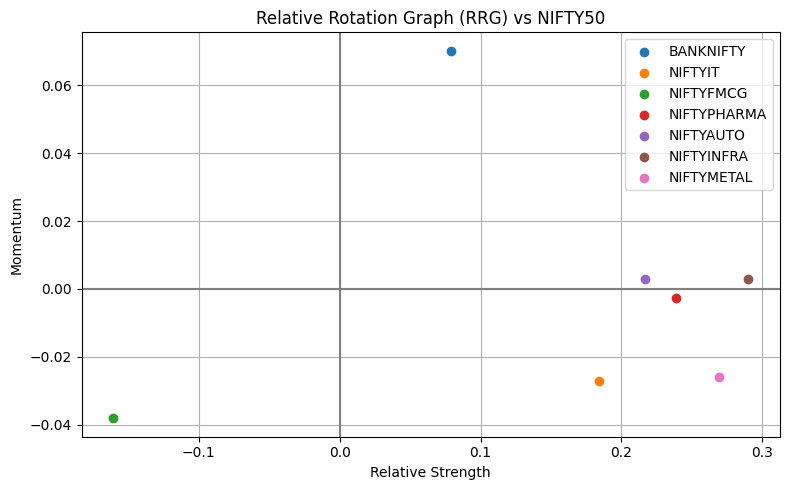

In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Define tickers
tickers = {
    "NIFTY50": "^NSEI",
    "BANKNIFTY": "^NSEBANK",
    "NIFTYIT": "^CNXIT",
    "NIFTYFMCG": "^CNXFMCG",
    "NIFTYPHARMA": "^CNXPHARMA",
    "NIFTYAUTO": "^CNXAUTO",
    "NIFTYINFRA": "^CNXINFRA",
    "NIFTYMETAL": "^CNXMETAL"
}

# Download data
data = yf.download(list(tickers.values()), start="2024-01-01", end="2025-06-27")['Close']
data.columns = tickers.keys()

# Daily returns
returns = data.pct_change().dropna()

# Relative returns to NIFTY50
relative_returns = returns.div(returns["NIFTY50"], axis=0)

# Rolling mean and momentum
relative_strength = relative_returns.rolling(window=14).mean()
momentum = relative_strength.diff()

# Normalize
scaler = StandardScaler()
rs_scaled = scaler.fit_transform(relative_strength.drop(columns="NIFTY50").dropna())
mo_scaled = scaler.fit_transform(momentum.drop(columns="NIFTY50").dropna())

# Latest values
x = rs_scaled[-1]
y = mo_scaled[-1]
labels = relative_strength.columns.drop("NIFTY50")

# Plot RRG
plt.figure(figsize=(8, 5))
plt.axhline(0, color='grey')
plt.axvline(0, color='grey')

for i, label in enumerate(labels):
    plt.scatter(x[i], y[i], label=label)
    #plt.text(x[i] + 0.02, y[i] + 0.02, label, fontsize=12)

plt.title("Relative Rotation Graph (RRG) vs NIFTY50")
plt.xlabel("Relative Strength")
plt.ylabel("Momentum")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


[*********************100%***********************]  11 of 11 completed


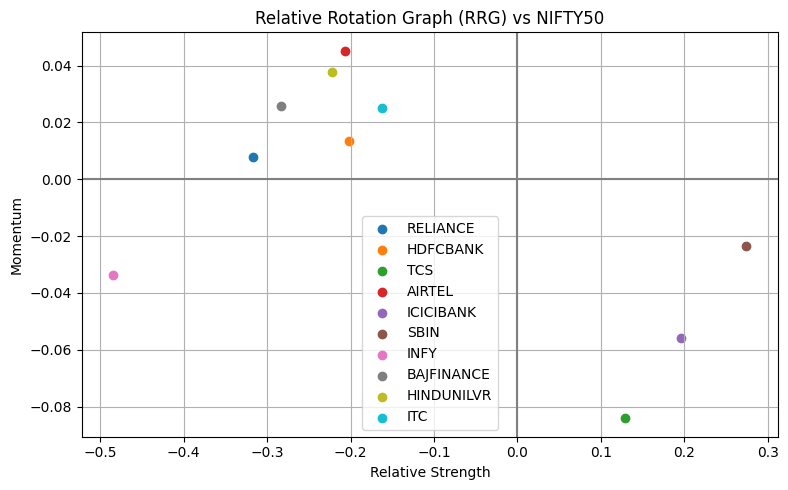

In [6]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

index = 'NIFTY50'

# Define tickers
tickers = {
    "NIFTY50": "^NSEI",
    "RELIANCE": "RELIANCE.NS",
    "HDFCBANK": "HDFCBANK.NS",
    "TCS": "TCS.NS",
    "AIRTEL": "BHARTIARTL.NS",
    "ICICIBANK": "ICICIBANK.NS",
    "SBIN": "SBIN.NS",
    "INFY": "INFY.NS",
    "BAJFINANCE": "BAJFINANCE.NS",
    "HINDUNILVR": "HINDUNILVR.NS",
    "ITC": "ITC.NS"
}

# Download data
data = yf.download(list(tickers.values()), start="2024-01-01", end="2025-06-28")['Close']
data.columns = tickers.keys()

# Daily returns
returns = data.pct_change().dropna()

# Relative returns to NIFTY50
relative_returns = returns.div(returns[index], axis=0)

# Rolling mean and momentum
relative_strength = relative_returns.rolling(window=14).mean()
momentum = relative_strength.diff()

# Normalize
scaler = StandardScaler()
rs_scaled = scaler.fit_transform(relative_strength.drop(columns=index).dropna())
mo_scaled = scaler.fit_transform(momentum.drop(columns=index).dropna())

# Latest values
x = rs_scaled[-1]
y = mo_scaled[-1]
labels = relative_strength.columns.drop(index)

# Plot RRG
plt.figure(figsize=(8, 5))
plt.axhline(0, color='grey')
plt.axvline(0, color='grey')

for i, label in enumerate(labels):
    plt.scatter(x[i], y[i], label=label)
    #plt.text(x[i] + 0.02, y[i] + 0.02, label, fontsize=12)

plt.title("Relative Rotation Graph (RRG) vs "+ index)
plt.xlabel("Relative Strength")
plt.ylabel("Momentum")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


[                       0%                       ]

['SUNPHARMA', 'DRREDDY', 'CIPLA', 'DIVISLAB', 'LUPIN', 'AUROPHARMA', 'TORNTPHARM']


[*********************100%***********************]  8 of 8 completed


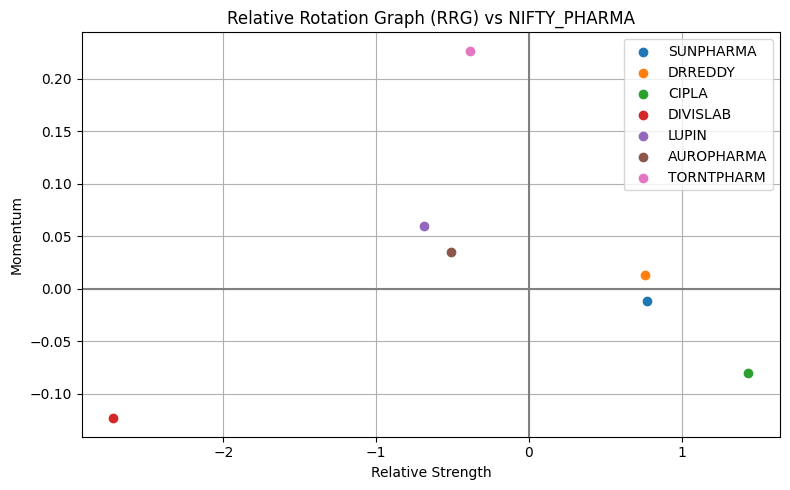

In [7]:
# function to fetch my prospects csv
def get_mysector_df():
  mysector_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/NSE_Sectors_Indices.csv')
  return mysector_df

sector_key_item = 'PHARMA'
sector_value_item = '^CNXPHARMA'

df = get_mysector_df()
stock_key_list = df[df['Sector'] == sector_key_item]['Symbol']
stock_key_list = list(stock_key_list)
suffix = ".NS"
stock_value_list = list(stock_key_list)

# 1. Suffix each item except the first
for i in range(0, len(stock_value_list)):
    stock_value_list[i] = stock_value_list[i] + suffix

print(stock_key_list)
# 2. Add the new item to the list
stock_key_list.append(sector_key_item)
stock_value_list.append(sector_value_item)

# Download data
data = yf.download(list(stock_value_list), start="2024-01-01", end="2025-06-28")['Close']
data.columns = stock_key_list

# Daily returns
returns = data.pct_change().dropna()

# Relative returns to NIFTY50
relative_returns = returns.div(returns[sector_key_item], axis=0)

# Rolling mean and momentum
relative_strength = relative_returns.rolling(window=14).mean()
momentum = relative_strength.diff()

# Normalize
scaler = StandardScaler()
rs_scaled = scaler.fit_transform(relative_strength.drop(columns=sector_key_item).dropna())
mo_scaled = scaler.fit_transform(momentum.drop(columns=sector_key_item).dropna())

# Latest values
x = rs_scaled[-1]
y = mo_scaled[-1]
labels = relative_strength.columns.drop(sector_key_item)

# Plot RRG
plt.figure(figsize=(8, 5))
plt.axhline(0, color='grey')
plt.axvline(0, color='grey')

for i, label in enumerate(labels):
    plt.scatter(x[i], y[i], label=label)
    #plt.text(x[i] + 0.02, y[i] + 0.02, label, fontsize=12)

plt.title("Relative Rotation Graph (RRG) vs NIFTY_" + sector_key_item)
plt.xlabel("Relative Strength")
plt.ylabel("Momentum")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# function to fetch screener data
def get_myscreen_df():
  myscreen_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myScreenerDB.csv')
  return myscreen_df
cols = ['Symbol', 'ATH%', 'PE', 'EPS', 'PB', 'MCap', 'ROCE%', 'ROE%',
       'Sales_Grwth%', 'Profit_Grwth%', 'MedPE',
       'Debt2EqR', 'PAT_12M', 'CFO_2_EBITDA%', 'CapType']
myscreen_df = get_myscreen_df()[cols]

# function to fetch screener data
def get_mypps_df():
  mypps_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myProspectsScrips.csv')
  return mypps_df
mypps_df = get_mypps_df()
my_analysis_df = pd.merge(mypps_df, myscreen_df, on='Symbol', how='left')
my_analysis_df['Conviction']  = my_analysis_df['Conviction'] + '-' + my_analysis_df['CapType']
my_analysis_df

def are_smas_tightly_clustered(symbol: str, threshold_percent: float = 3.0):
    data = yf.download(symbol + '.NS', period='550d', progress=False)
    data = data[data.index < '2025-06-18']
    if data.empty:
        return {"Symbol": symbol, "spread_%": None, "error": "No data"}

    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()


    try:
        latest = data.dropna().iloc[-1]
        sma_20 = latest['SMA_20']
        sma_50 = latest['SMA_50']
        sma_200 = latest['SMA_200']
        price = latest['Close']

        # Calculate spreads
        max_sma = max(sma_20.item(), sma_50.item(), sma_200.item())
        min_sma = min(sma_20.item(), sma_50.item(), sma_200.item())
        abs_spread = max_sma - min_sma
        pct_spread = (abs_spread / sma_200) * 100

        return {
            "Symbol": symbol,
            "Spread_%": round(pct_spread[0], 2)
        }
    except:
        return {"Symbol": symbol, "Spread_%": None, "Error": "Insufficient data"}

# ✅ Function to loop through multiple scrips
def check_multiple_scrips(scrip_list, threshold=3.0):
    results = []
    for scrip in scrip_list:
        result = are_smas_tightly_clustered(scrip, threshold_percent=threshold)
        #print(result["Spread_%"])
        results.append(result)
    return pd.DataFrame(results)

# 🧪 Example usage
scrips = ['RAYMOND']#mypps_df['Symbol'].values

df_result = check_multiple_scrips(scrips)
my_analysis_df = pd.merge(my_analysis_df, df_result, on='Symbol')
cols = ['Symbol', 'Conviction', 'Spread_%', 'InFolio']
my_analysis_df[cols]

,Symbol,Conviction,Spread_%,InFolio
0,RAYMOND,M-SC,57.94,NaN


In [9]:
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

myscreen_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myScreenerDB.csv')
mypps_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myProspectsScrips.csv')


In [10]:
list(set(myscreen_df[myscreen_df['CapType'] == 'LC']['Symbol'].values) - set(mypps_df[mypps_df['Conviction'] == 'X']['Symbol'].values))

['INDIANB',
 'TORNTPHARM',
 'TMCV',
 'BANKBARODA',
 'ADANIENT',
 'HEROMOTOCO',
 'CUMMINSIND',
 'POWERGRID',
 'TECHM',
 'TATAPOWER',
 'BEL',
 'LICI',
 'SIEMENS',
 'UNIONBANK',
 'AMBUJACEM',
 'POLYCAB',
 'SBILIFE',
 'TATACONSUM',
 'TVSMOTOR',
 'HINDZINC',
 'INDUSTOWER',
 'CANBK',
 'LTIM',
 'HINDALCO',
 'INDIGO',
 'CGPOWER',
 'VEDL',
 'MOTHERSON',
 'ADANIGREEN',
 'GRASIM',
 'CHOLAFIN',
 'GAIL',
 'TATACAP',
 'BHARTIARTL',
 'HAL',
 'WIPRO',
 'TATAMOTORS',
 'PFC',
 'IOC',
 'SHRIRAMFIN',
 'ENRIN',
 'JINDALSTEL',
 'TRENT',
 'MAZDOCK',
 'MUTHOOTFIN',
 'PNB',
 'SOLARINDS',
 'ONGC',
 'DIVISLAB',
 'IDEA',
 'LODHA',
 'ADANIPOWER',
 'BRITANNIA',
 'TATASTEEL',
 'LGEINDIA',
 'COALINDIA',
 'JSWSTEEL',
 'SUNPHARMA',
 'BPCL',
 'DLF',
 'ETERNAL',
 'ADANIENSOL',
 'NTPC',
 'IRFC']

In [7]:
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# function to fetch screener data
def get_myscreen_df():
  myscreen_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myScreenerDB.csv')
  return myscreen_df
cols = ['Symbol', 'ATH%', 'PE', 'EPS', 'PB', 'MCap', 'ROCE%', 'ROE%',
       'Sales_Grwth%', 'Profit_Grwth%', 'MedPE',
       'Debt2EqR', 'PAT_12M', 'CFO_2_EBITDA%', 'CapType']
myscreen_df = get_myscreen_df()[cols]

# function to fetch screener data
def get_mypps_df():
  mypps_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myProspectsScrips.csv')
  return mypps_df
mypps_df = get_mypps_df()
my_analysis_df = pd.merge(myscreen_df, mypps_df, on='Symbol', how='left')
my_analysis_df['Conviction']  = my_analysis_df['Conviction'] + '-' + my_analysis_df['CapType']
my_analysis_df

,Symbol,ATH%,PE,EPS,PB,MCap,ROCE%,ROE%,Sales_Grwth%,Profit_Grwth%,...,StarStock,CumlRnk,Conviction,Category,InFolio,Cyclical,XIRR,Remarks,MBQ,Reasoning
0,RELIANCE,6.51,26.66,61.41,2.33,2043876.70,9.69,8.40,8.08,12.85,...,0.0,17.0,X-LC,REFINERIES,1.0,SC,67.0,NaN,XY25/X40/X5K,Diversified conglomerate with leading position...
1,HDFCBANK,3.42,20.97,47.22,2.81,1517448.80,7.51,14.45,7.51,4.60,...,1.0,25.0,X-LC,BANKS,NaN,NC,4.0,NaN,X40/X5K,Best-in-class private bank with robust growth ...
2,BHARTIARTL,2.25,38.91,67.62,10.11,1253057.59,13.48,23.18,25.17,127.00,...,1.0,38.0,H-LC,TELECOM,NaN,SC,NaN,NaN,X5K,Leading telecom operator with improved profita...
3,TCS,47.85,22.35,136.64,10.56,1123975.37,64.63,52.38,3.62,4.43,...,1.0,1.0,X-LC,IT,1.0,NC,8.0,NaN,X40/X5K,IT services giant with unparalleled scale exec...
4,ICICIBANK,8.23,18.58,74.91,3.14,990378.27,7.87,17.89,10.50,12.52,...,1.0,6.0,X-LC,BANKS,NaN,NC,NaN,NaN,X40/X5K,Best-in-class private bank with consistent gro...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,BLUSPRING,11.56,55.10,NaN,NaN,1188.34,NaN,NaN,NaN,NaN,...,1.0,260.0,L-SC,MISC,NaN,NC,NaN,NaN,XY24,NaN
799,5PAISA,106.33,18.76,19.61,2.00,1148.55,12.89,10.29,39.09,9.46,...,0.0,161.0,H-SC,FINANCE,1.0,NC,20.0,SD: V20 598,OX40N,Competitive discount brokerage with a growing ...
800,VALIANTORG,623.61,NaN,-10.20,1.06,761.26,1.07,-0.91,20.45,21.02,...,0.0,149.0,H-SC,CHEMICALS,1.0,SC,-27.0,NaN,XR,Specialty chemical player with strong margins ...
801,ASIANTILES,744.91,382.70,0.49,0.53,677.37,1.23,-0.91,24.18,5.57,...,0.0,271.0,L-SC,CERAMICS,NaN,SC,-16.0,NaN,XR,Tile manufacturer with consistent performance ...


In [8]:
cols = ['Symbol', 'MCap', 'CumlRnk', 'Conviction', 'InFolio', 'ATH%']
my_analysis_df[my_analysis_df['Conviction'].isin(['X-LC','H-LC','X-MC'])][cols].sort_values(by = 'ATH%', ascending=False)

,Symbol,MCap,CumlRnk,Conviction,InFolio,ATH%
247,AWL,35526.74,58.0,X-MC,1.0,221.45
179,COLPAL,59140.55,61.0,X-MC,1.0,79.05
61,TMPV,146520.55,3.0,X-LC,1.0,78.94
127,BAJAJHFL,89672.65,64.0,X-MC,1.0,75.12
46,DLF,189671.50,40.0,H-LC,NaN,59.96
...,...,...,...,...,...,...
43,SBILIFE,199009.34,51.0,H-LC,NaN,1.74
199,MCX,48977.04,70.0,X-MC,NaN,1.73
10,LT,550296.24,20.0,X-LC,NaN,1.59
72,TORNTPHARM,129769.56,44.0,H-LC,NaN,1.30


In [12]:
import yfinance as yf

def risk_reward_52w(stock_symbol):
    try:
        stock = yf.Ticker(stock_symbol)
        hist = stock.history(period="1y")

        if hist.empty:
            return None

        current_price = hist["Close"][-1]
        high_52w = hist["High"].max()
        low_52w = hist["Low"].min()

        risk_pct = ((current_price - low_52w) / low_52w) * 100
        reward_pct = ((high_52w - current_price) / current_price) * 100
        risk_reward_ratio = reward_pct / risk_pct if risk_pct != 0 else None

        return {
            "Stock": stock_symbol,
            "CurrentPrice": round(current_price, 2),
            "52W_High": round(high_52w, 2),
            "52W_Low": round(low_52w, 2),
            "Risk_(%)": round(risk_pct, 2),
            "Reward_(%)": round(reward_pct, 2),
            "Risk_Reward_Ratio": round(risk_reward_ratio, 2) if risk_reward_ratio else None
        }

    except Exception as e:
        return None

import pandas as pd

def risk_reward_df(stock_list):
    results = []

    for stock in stock_list:
        data = risk_reward_52w(stock + '.NS')
        if data:
            results.append(data)

    return pd.DataFrame(results)


In [15]:

stocks = my_analysis_df[my_analysis_df['Conviction'].isin(['X-LC','H-LC','X-MC'])]['Symbol'].values
df = risk_reward_df(stocks)
df.sort_values(by = 'Risk_Reward_Ratio', ascending=False).head(20)


,Stock,CurrentPrice,52W_High,52W_Low,Risk_(%),Reward_(%),Risk_Reward_Ratio
73,PAGEIND.NS,35775.00,50257.30,35310.00,1.32,40.48,30.74
72,UBL.NS,1596.40,2287.92,1574.10,1.42,43.32,30.58
45,ENRIN.NS,2546.70,3625.00,2508.80,1.51,42.34,28.03
11,ITC.NS,350.05,457.02,345.25,1.39,30.56,21.98
68,COLPAL.NS,2090.10,2911.55,2051.00,1.91,39.30,20.62
80,AWL.NS,236.27,333.00,231.55,2.04,40.94,20.08
60,DIXON.NS,12165.00,18691.68,11646.00,4.46,53.65,12.04
63,BAJAJHFL.NS,96.62,136.96,92.10,4.91,41.75,8.51
61,HAVELLS.NS,1439.90,1710.26,1376.01,4.64,18.78,4.04
42,BAJAJHLDNG.NS,11181.00,14690.34,10174.09,9.90,31.39,3.17
